In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Module 1

## Lecture 1

### **1**

Let's consider a waveform, which represents different sounds:

![](./images/3-s2.0-B9780128130865000037-f05-09-9780128130865.jpg)

Can we decompose an arbitrary wave into Fourier series with high precision? - Yes, but with a very high value of N.

> <span style="color:red">**TODO**</span>: Why?

Because the Fourier series seeks to represent the input signal using a new **orthogonal basis**:

$$\left\{ 1, \cos \left( 2\pi n x \right), \sin \left( 2\pi n x \right) \right\} _{n = 1}^{\infty}$$

Since the signal is high-dimensional in the function space, the number **N** determines how many basis components we use in the approximation — similar to a **rank-N approximation in SVD**, where more components capture more structure in the original data.

Thus, using a large **N** allows capture more high-frequency components and finer details of the signal, resulting in a more precise approximation.

### **2**


But in practice having such a big N value is not reasonable because:

- We again get high resolution data.
- It is an "overfit".

Let's consider an alternative approach. One way to simplify a complex waveform is to split it into windows. "Window" waveforms are much less complex.

> <span style="color:red">**TODO**</span>: Why?


Because each window covers only a short segment of the full waveform, it likely contains fewer frequency components and less variation. Over a short duration, the signal tends to be more stable, making it simpler and easier to model with fewer Fourier terms. By analyzing smaller windows, we reduce the signal’s complexity in each part, avoiding the need for a high **N** over the entire waveform.

### **3**

> <span style="color:red">**TODO**</span>: How does resampling work?

There are two main types of resampling: **upsampling** and its opposite, **downsampling**.

**Upsampling** increases the sampling rate. In the basic approach, empty slots of the same size are inserted between existing samples, often initialized with zeros. These gaps are then filled using interpolation techniques to estimate the missing values. More advanced methods, such as Fourier-based imputing, can also be used to improve the accuracy of the reconstructed signal.

**Downsampling**, on the other hand, reduces the sampling rate. The most basic and least effective method is to simply drop samples at regular intervals to achieve the desired size. More sophisticated approaches apply averaging over a fixed-size window, such as a rolling average, to preserve more of the signal's structure and reduce aliasing.

### **4**

> <span style="color:red">**TODO**</span>: Why does resampling "not work" in the Spectral domain?

Because changes in one domain affect the other non-linearly, resampling directly in the frequency domain often does not produce the desired result. For example, downsampling by simply removing high-frequency components causes loss of phase information, which in turn leads to aliasing and distortion in the reconstructed signal.

## Lecture 2

> <font color='red'>**TODO**</font>: Implement Butterworth Filter from scratch.

In [35]:
from scipy.signal import bilinear

def butterworth_coeffs(cutoff_freq, fs, order=4):
    warped = 2 * fs * np.tan(np.pi * cutoff_freq / fs)
    poles = []
    for k in range(1, 2 * order, 2):
        angle = np.pi * k / (2 * order)
        pole = warped * np.exp(1j * (np.pi / 2 + angle))
        poles.append(pole)
    poles = np.array(poles)

    a_analog = np.poly(poles).real
    b_analog = np.array([warped ** order])

    b, a = bilinear(b_analog, a_analog, fs)
    return b, a


def apply_filter(b, a, x):
    y = np.zeros_like(x)
    order = len(a) - 1

    for n in range(len(x)):
        xn = x[n]
        yn = b[0] * xn
        for i in range(1, order + 1):
            if n - i >= 0:
                yn += b[i] * x[n - i] - a[i] * y[n - i]
            else:
                yn += b[i] * 0 - a[i] * 0 
        y[n] = yn
    return y

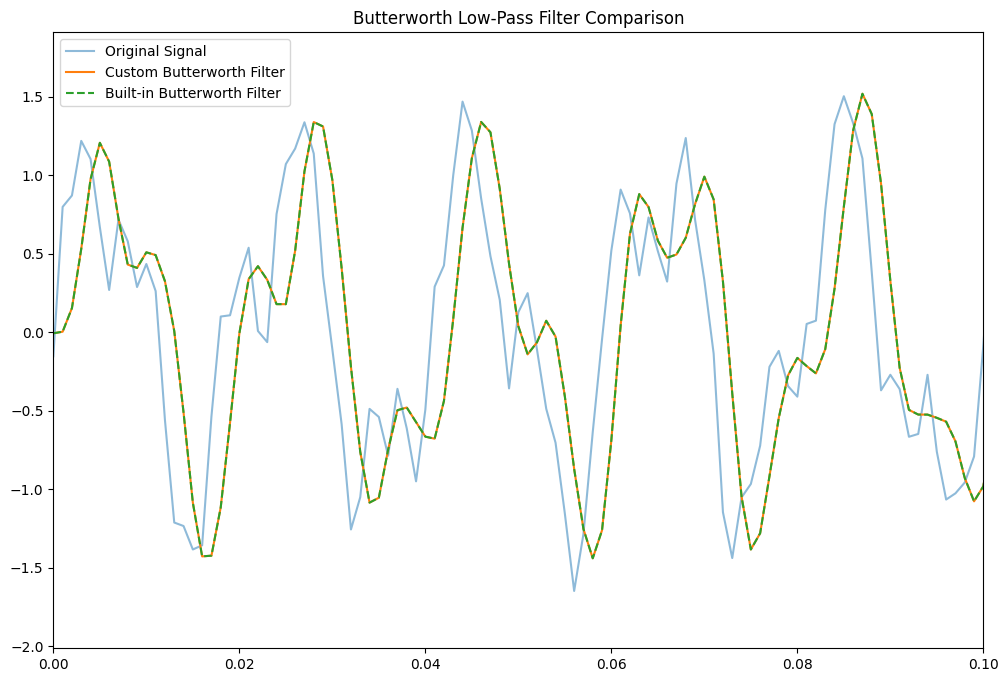

In [38]:
from scipy.signal import butter, lfilter

fs = 1000
t = np.linspace(0, 1, fs, endpoint=False)

x = np.sin(2* np.pi * 50 * t) + 0.5 * np.sin(2 * np.pi * 120 * t) + 0.2 * np.sin(2 * np.pi * 300 * t)
x += 0.1 * np.random.randn(len(t))

cutoff = 200
order = 4

b_custom, a_custom = butterworth_coeffs(cutoff, fs, order)

y_custom = apply_filter(b_custom, a_custom, x)

b_builtin, a_builtin = butter(order, cutoff, fs=fs, btype='low')
y_builtin = lfilter(b_builtin, a_builtin, x)

plt.figure(figsize=(12, 8))
plt.plot(t, x, label='Original Signal', alpha=0.5)
plt.plot(t, y_custom, label='Custom Butterworth Filter')
plt.plot(t, y_builtin, label='Built-in Butterworth Filter', linestyle='--')
plt.xlim(0, 0.1)
plt.legend()
plt.title("Butterworth Low-Pass Filter Comparison")
plt.show()

# Module 1

## Lecture 1

> <span style="color:red">**TODO**</span>: Explore ["Confidence intervals for evaluation in machine learning"](https://github.com/luferrer/ConfidenceIntervals/tree/main)

## Lecture 4

### **1**

> <font style="color:red">**TODO**</font>: Implement "UniversalSlicer", which will be able to cut/pad waves to pre-defined length and batch them. Implement different cutting/padding policies, for example, right/left pad, cut to fixed length or by silence regions (2+ points).

In [164]:
import torchaudio

class UniversalSlicer:
    def __init__(self, sampling_rate: int, 
                       target_length: int = -1, 
                       padding: str = 'both',
                       cut_mode: str = 'both',
                       cut_silence: bool = False,
                       interval_factor: int = 50,
                       silence_threshold: float = 1e-2):
        """
            mode = left, right or both
        """
        self.__target_length = target_length
        self.__sampling_rate = sampling_rate
        self.__padding = padding
        self.__cut_mode = cut_mode
        self.__cut_silence = cut_silence
        self.__silence_thresh = silence_threshold
        self.__interval_factor = interval_factor


    def silent(self, wave: np.ndarray):
        mask = wave > self.__silence_thresh
        indices = np.where(mask.astype(int))[0]

        if len(indices) == 0:
            return []

        gaps = np.diff(indices) > 1
        split_points = np.where(gaps)[0] + 1

        segments = np.split(indices, split_points)

        intervals = [(seg[0], seg[-1] + 1) for seg in segments if len(seg) > 0]
        return intervals


    def merge_intervals(self, intervals, n):
        if not intervals:
            return []

        intervals.sort()
        merged = [intervals[0]]

        for start, end in intervals[1:]:
            prev_start, prev_end = merged[-1]

            if start - prev_end < n:
                merged[-1] = (prev_start, max(prev_end, end))
            else:
                merged.append((start, end))

        filtered = [(s, e) for (s, e) in merged if (e - s) >= n]
        return filtered


    def padding(self, wave: np.ndarray, target_size: int, mode: str = "both"):
        if len(wave) > target_size:
            raise ValueError("Padded audio is bigger than target")
        padding_size = target_size - len(wave)

        if mode == "both":
            left = np.zeros(padding_size // 2)
            right = np.zeros(padding_size // 2 + padding_size % 2)
            return np.concat([left, wave, right])
        elif mode == "left":
            return np.concatenate([np.zeros(padding_size), wave])
        elif mode == "right":
            return np.concatenate([wave, np.zeros(padding_size)])
        else:
            raise ValueError("Incorrect mode")

        
    def cut_silence(self, wave: np.ndarray):
        intervals = self.silent(wave)
        merged_intervals = self.merge_intervals(intervals, self.__sampling_rate // self.__interval_factor)
        if not merged_intervals:
            return np.array([])

        merged_audio = wave[merged_intervals[0][0]:merged_intervals[0][1] + 1]
        for i in range(1, len(merged_intervals)):
            merged_audio = np.concatenate([merged_audio, wave[merged_intervals[i][0]:merged_intervals[i][1] + 1]])
        return merged_audio


    def cut(self, wave: np.ndarray, target_size: int, mode: str = "both"):
        if target_size > len(wave):
            raise ValueError("Cutting audio is smaller than target")
        cutting_size = len(wave) - target_size

        if mode == "both":
            left = cutting_size // 2
            right = cutting_size // 2 + cutting_size % 2
            return wave[left:-right]
        elif mode == "left":
            return wave[cutting_size:]
        elif mode == "right":
            return wave[:-cutting_size]
        else:
            raise ValueError("Incorrect mode")


    def process(self, wave: np.ndarray, batch_size: int = 1):
        if self.__cut_silence:
            wave = self.cut_silence(wave)
        if self.__target_length == -1:
            return wave

        if self.__target_length < len(wave):
            wave = self.cut(wave, self.__target_length, self.__cut_mode)
        else:
            wave = self.padding(wave, self.__target_length, self.__padding)

        if batch_size == 1:
            return wave

        batch_len = len(wave) // batch_size
        if len(wave) % batch_size > 0:
            batch_len += 1
        wave = self.padding(wave, batch_size * batch_len, self.__padding)
        return wave.reshape(batch_size)


def load_flac(path):
    waveform, sample_rate = torchaudio.load(path)
    return waveform[0].numpy(), sample_rate 


def plot_audio_comparison(original: np.ndarray, processed: np.ndarray, sr: int, title: str = "Audio Comparison"):
    time_orig = np.arange(len(original)) / sr
    time_proc = np.arange(len(processed)) / sr

    print(f"Original length: {len(original)} samples ({len(original)/sr:.2f} s)")
    print(f"Processed length: {len(processed)} samples ({len(processed)/sr:.2f} s)")

    fig, axs = plt.subplots(2, 1, figsize=(14, 6), sharex=False)
    fig.suptitle(title)

    axs[0].plot(time_orig, original, label="Original", color='blue')
    axs[0].set_title("Original Waveform")
    axs[0].set_ylabel("Amplitude")

    axs[1].plot(time_proc, processed, label="Processed", color='orange')
    axs[1].set_title("Processed Waveform")
    axs[1].set_ylabel("Amplitude")
    axs[1].set_xlabel("Time [s]")

    plt.tight_layout()
    plt.show()

#### **Cut**

Original length: 217280 samples (13.58 s)
Processed length: 180000 samples (11.25 s)


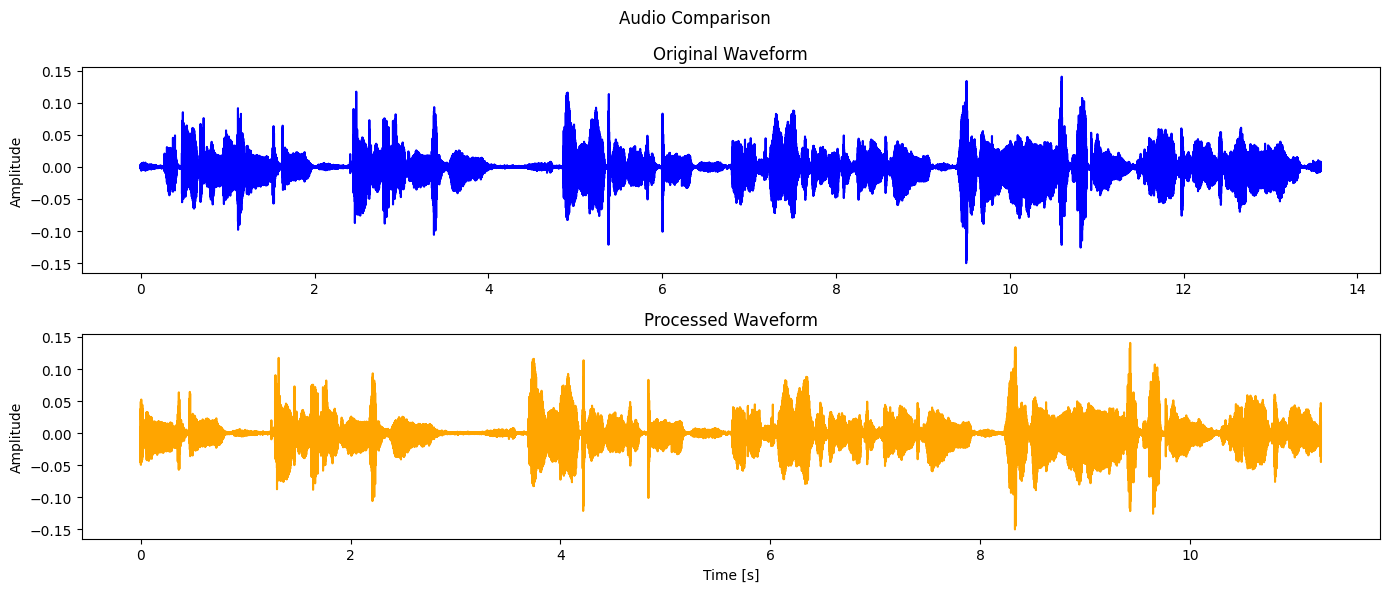

In [155]:
audio, sr = load_flac("./audio/audio8.flac")
slicer = UniversalSlicer(sr, 180000, cut_mode="both")
audio_processed = slicer.process(audio)

plot_audio_comparison(audio, audio_processed, sr)

Original length: 217280 samples (13.58 s)
Processed length: 180000 samples (11.25 s)


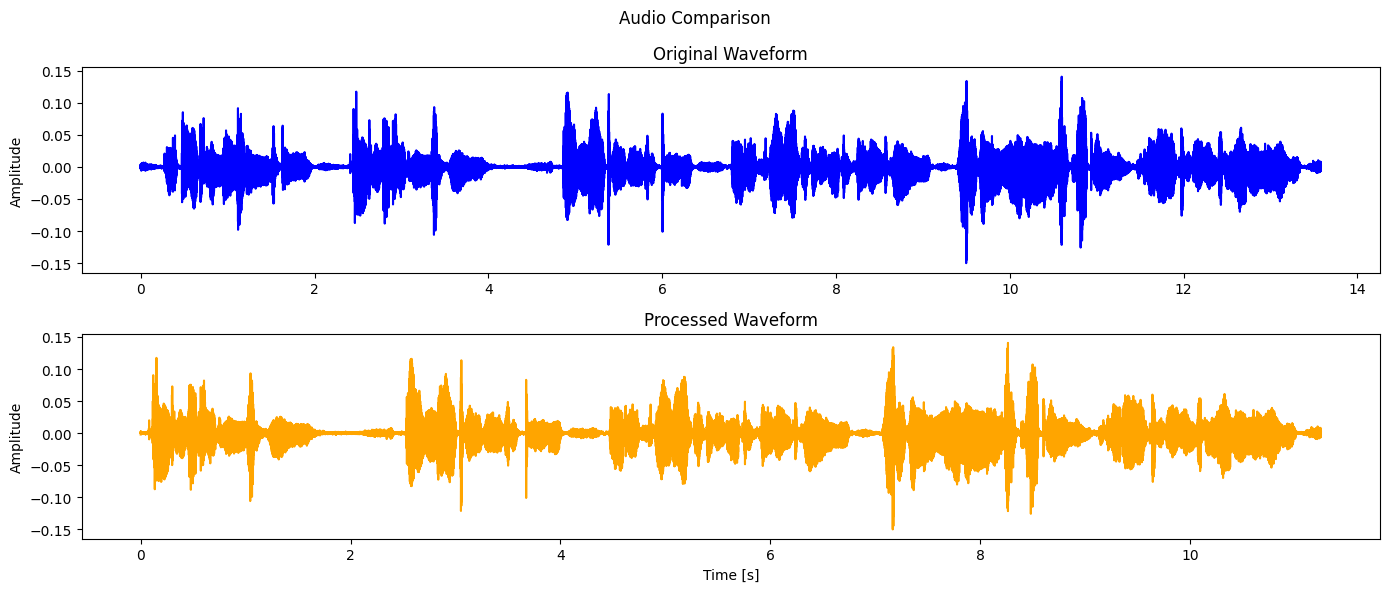

In [156]:
audio, sr = load_flac("./audio/audio8.flac")
slicer = UniversalSlicer(sr, 180000, cut_mode="left")
audio_processed = slicer.process(audio)

plot_audio_comparison(audio, audio_processed, sr)

Original length: 217280 samples (13.58 s)
Processed length: 180000 samples (11.25 s)


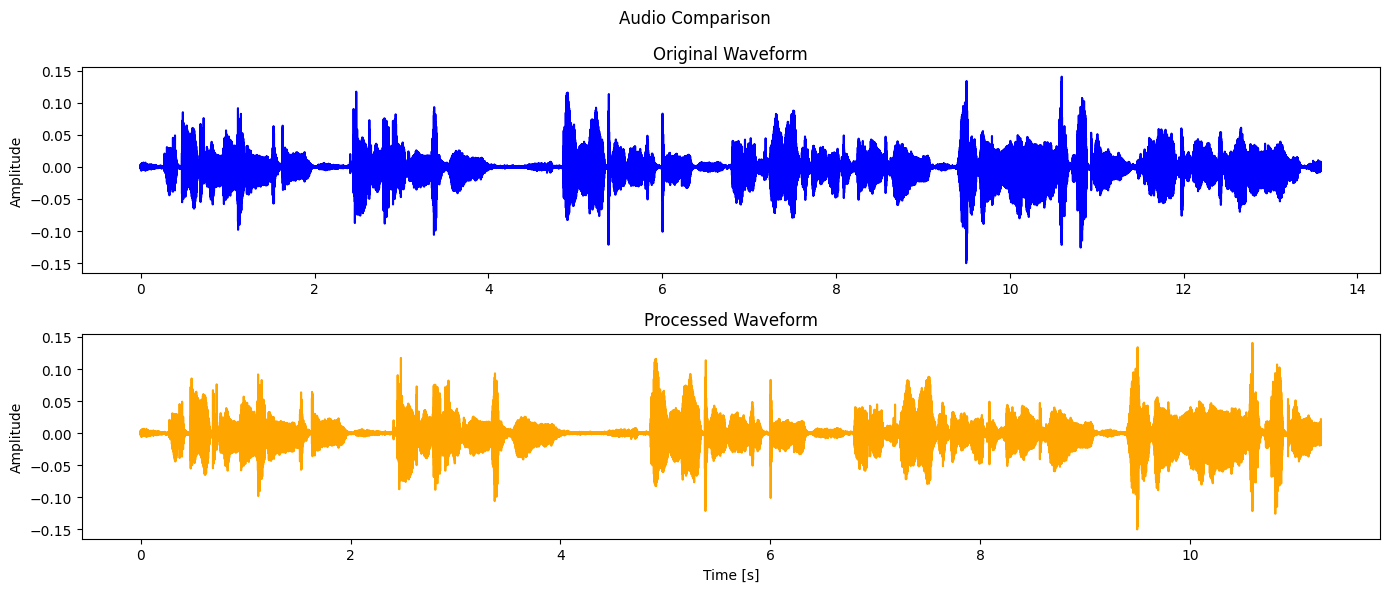

In [159]:
audio, sr = load_flac("./audio/audio8.flac")
slicer = UniversalSlicer(sr, 180000, cut_mode="right")
audio_processed = slicer.process(audio)

plot_audio_comparison(audio, audio_processed, sr)

Original length: 217280 samples (13.58 s)
Processed length: 151339 samples (9.46 s)


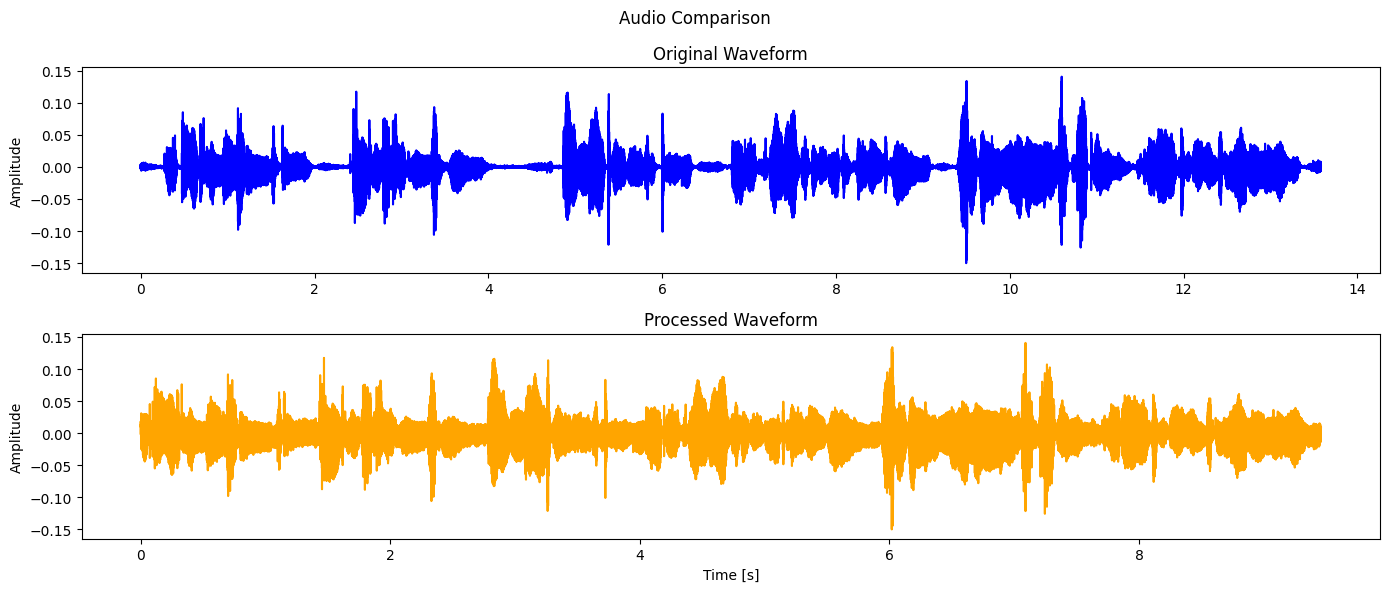

In [165]:
audio, sr = load_flac("./audio/audio8.flac")
slicer = UniversalSlicer(sr, -1, cut_silence=True)
audio_processed = slicer.process(audio)

plot_audio_comparison(audio, audio_processed, sr)

#### Padding

Original length: 217280 samples (13.58 s)
Processed length: 250000 samples (15.62 s)


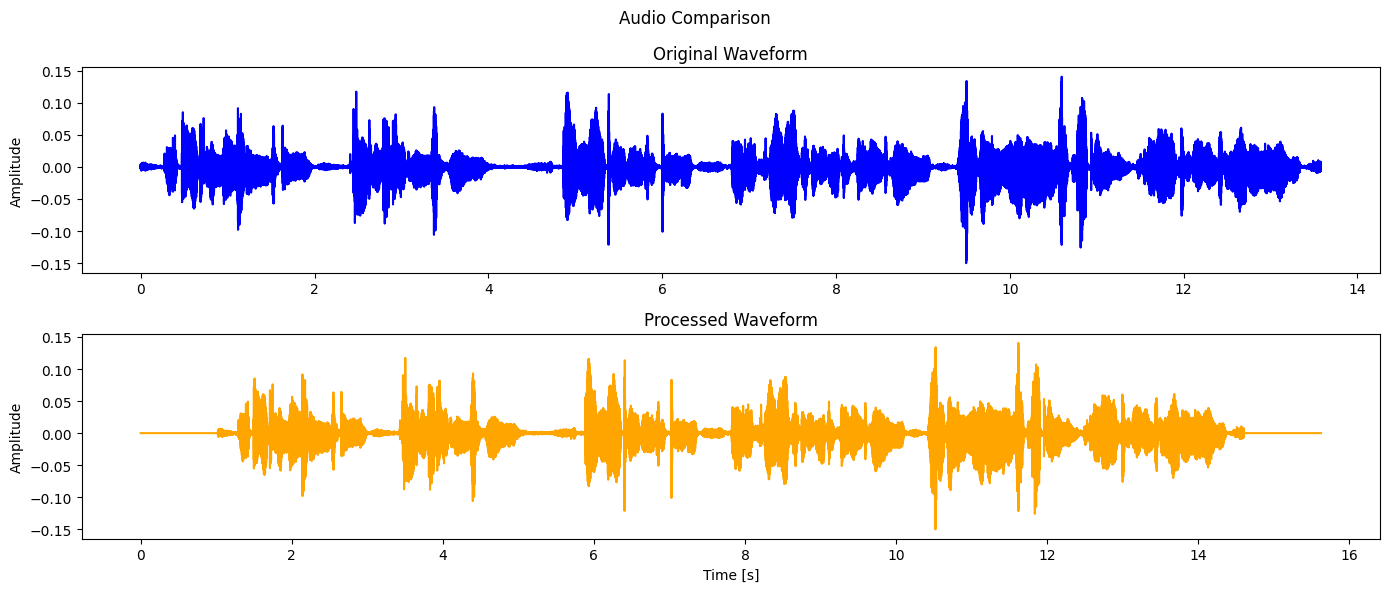

In [166]:
audio, sr = load_flac("./audio/audio8.flac")
slicer = UniversalSlicer(sr, 250000, padding="both")
audio_processed = slicer.process(audio)

plot_audio_comparison(audio, audio_processed, sr)

Original length: 217280 samples (13.58 s)
Processed length: 250000 samples (15.62 s)


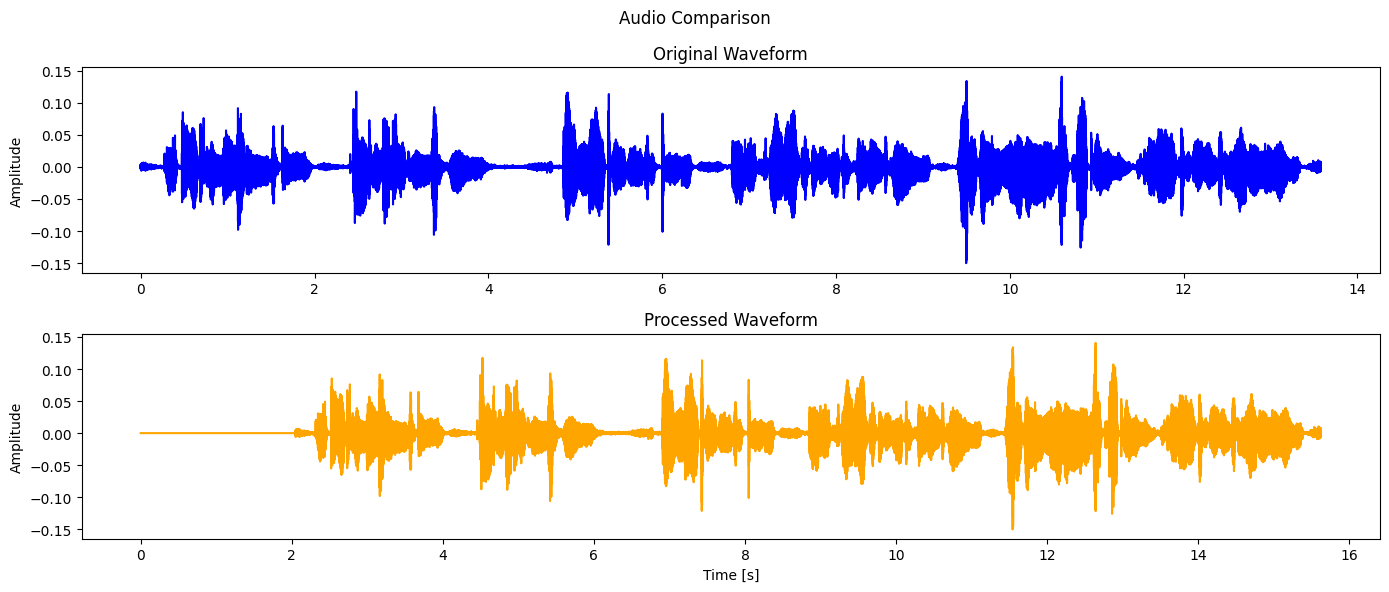

In [167]:
audio, sr = load_flac("./audio/audio8.flac")
slicer = UniversalSlicer(sr, 250000, padding="left")
audio_processed = slicer.process(audio)

plot_audio_comparison(audio, audio_processed, sr)

Original length: 217280 samples (13.58 s)
Processed length: 250000 samples (15.62 s)


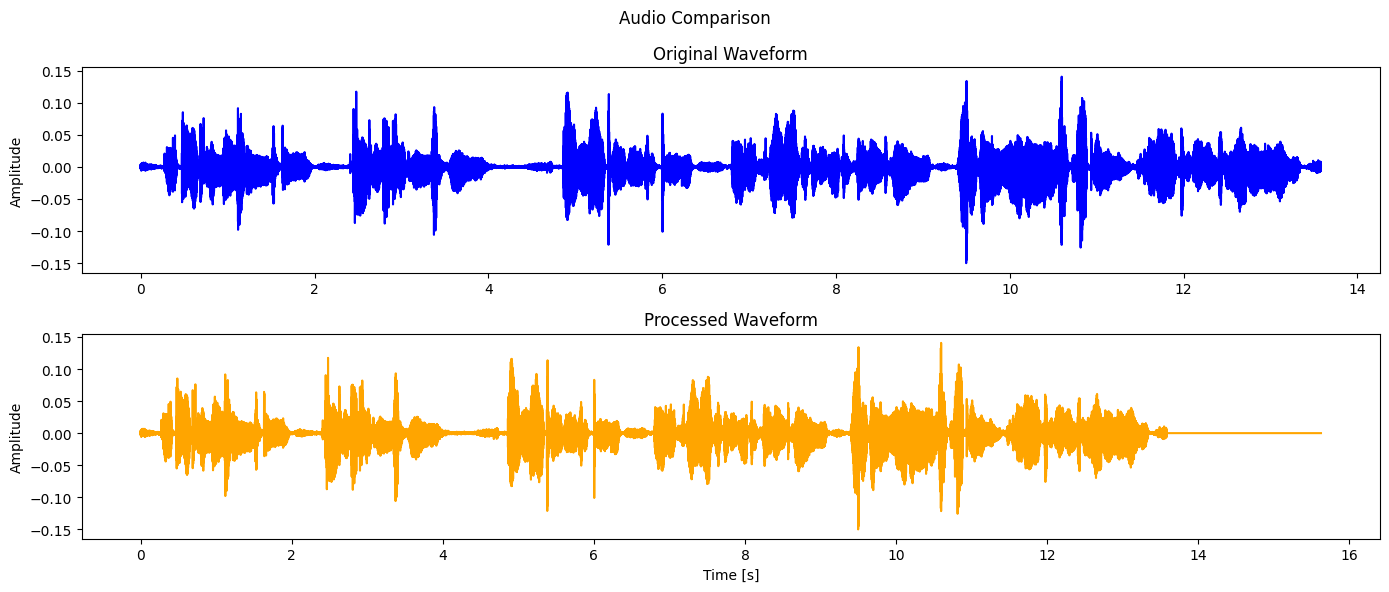

In [168]:
audio, sr = load_flac("./audio/audio8.flac")
slicer = UniversalSlicer(sr, 250000, padding="right")
audio_processed = slicer.process(audio)

plot_audio_comparison(audio, audio_processed, sr)

### **2**

In [ ]:
import torch
import torch.nn as nn

class Audio2SpecPad(nn.Module):
    def __init__(
        self,
        hop_size=512
    ):
        super().__init__()
        self.maxpool = nn.MaxPool1d(
            kernel_size=hop_size,
            stride=hop_size
        )
    
    def forward(self, audio_pads, time_max_length):
        spec_pads = self.maxpool(audio_pads.unsqueeze(1)).squeeze(1)
        pad = torch.ones(spec_pads.shape[0], time_max_length - spec_pads.shape[-1])
        spec_pads = torch.cat((pad, spec_pads), axis=1)
        return spec_pads
        
audio2spec_pad_layer = Audio2SpecPad()

> <font style="color:red">**TODO**</font>: Rewrite `Audio2SpecPad` and get rid of "hacky pad" (1 point)

### **3**

> <font style="color:red">**TODO**</font>: Explore [Wav2Vec2FeatureExtractor](https://huggingface.co/docs/transformers/model_doc/wav2vec2#transformers.Wav2Vec2FeatureExtractor). Can we rewrite it, so it takes on input batched torch.Tensor ? (1 point)

### **4**

> <span style="color:red">**TODO**</span>: Explore [Wav2Vec2Model](https://huggingface.co/docs/transformers/model_doc/wav2vec2#transformers.Wav2Vec2Model) docs and use `attention_mask` in order to optimize computations and unpad seuqnce in a bettter way (0.5 point).

### **5**

> <font style="color:red">**TODO**</font>: Check how to normalize outputs of [HubertForCTC](https://huggingface.co/docs/transformers/model_doc/hubert#transformers.HubertForCTC). *Simply put, make them in a format we had for W2V.* (2 points)

### **6**

In [ ]:
import torch
import librosa
from tqdm import tqdm
from transformers import (
    AutoTokenizer, AutoFeatureExtractor, AutoModelForCTC, 
    AutoProcessor, Wav2Vec2Model, HubertForCTC, 
    HubertModel, Data2VecAudioForCTC, Data2VecAudioModel,
    AutoModelForAudioXVector
)

class XVectorExtractor:
    def __init__(
        self,
        model_name,
        device="cpu",
        do_normalize=True
    ):
        self.feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
        self.model = AutoModelForAudioXVector.from_pretrained(model_name).to(device)
        self.do_normalize = do_normalize

    def extract_features(
        self,
        wave_pathes,
        sample_rate
    ):
        features = []
        for wave_path in tqdm(wave_pathes):
            wave, _ = librosa.load(wave_path, sr=sample_rate)
            inputs = self.feature_extractor([wave], sampling_rate=sample_rate, return_tensors="pt").input_values
            with torch.no_grad():
                embeddings = self.model(inputs.cuda()).embeddings
            if self.do_normalize:
                embeddings = torch.nn.functional.normalize(embeddings, dim=-1)
            embeddings = embeddings.cpu()
            features.append(embeddings)
        return torch.cat(features, dim=0)

> <font style="color:red">**TODO**</font>: Add batching (1 point).


### **7**


> <font style="color:red">**TODO**</font>: How to transform `Wav2Vec2Model` into `Wav2Vec2ForXVector` (0.5 point)?